# 歡迎來到 **OpenVINO Runtime API(推論引擎)架構與功能介紹** 課程的編程作業!

你將通過完成這份作業, 更加熟悉OpenVINO三步驟快速上手流程, 即:
- 建置 (Build)
- 優化 (Optimize)
- 部署 (Deploy)

在順利安裝[OpenVINO 2022.1 Dev Tools](https://www.intel.com/content/www/us/en/developer/tools/openvino-toolkit/download.html)
後, 你將按照所指示的資訊, 手把手完成建置, 優化, 以及部署的代碼實現.
- 下載目標影像和標記資料, 以及模型
- 使用[模型優化器](https://docs.openvino.ai/latest/openvino_docs_MO_DG_Deep_Learning_Model_Optimizer_DevGuide.html)將原預訓練模型轉換成[Intermediate Representation (IR)檔案](https://docs.openvino.ai/latest/openvino_docs_MO_DG_IR_and_opsets.html?highlight=intermediate%20representation)
- 利用[OpenVINO Runtime API(推論引擎)](https://docs.openvino.ai/latest/openvino_docs_OV_UG_OV_Runtime_User_Guide.html)做實際的推論與部署

### Import所需要的函示庫

In [1]:
import cv2
import os
import io
import PIL
import requests
import numpy as np
import matplotlib.pyplot as plt
from openvino.preprocess import PrePostProcessor, ResizeAlgorithm
from openvino.runtime import Core, Layout, Type
from urllib.request import urlopen

## 1.建置


### 1.1讀取推論目標影像(一張跑車的照片), 並且將它顯示出來做確認

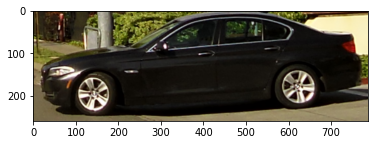

In [2]:
response = requests.get('https://drive.google.com/u/0/uc?id=1bINVmgR5Txrg7qvFIo5wm2UWUjRp0rBv&export=download')
image_bytes = io.BytesIO(response.content)

img = PIL.Image.open(image_bytes)
plt.imshow(img)

### 1.2下載標記資料 (squeezenet1.1 label), 並且將前五個項目印出來做確認

In [3]:
squeezenetlabel_url = 'https://drive.google.com/u/0/uc?id=1HXV2CPQw5yfJipBBWd0PJNXvmauX_hoI&export=download'
html = []

try:
    with urlopen(squeezenetlabel_url) as response:
        for line in response:
            html.append(line)
except HTTPError as e:
    print('The server couldn\'t fulfill the request.')
    print('Error code: ', e.code)
except URLError as e:
    print('We failed to reach a server.')
    print('Reason: ', e.reason)

labels = []
for i in html:
    i = str(i)
    i = i.replace('b', '').replace('\\r', '').replace('\\n', '')
    labels.append(i)
    
labels[:5]

["'tench, Tinca tinca'",
 "'goldfish, Carassius auratus'",
 "'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias'",
 "'tiger shark, Galeocerdo cuvieri'",
 "'hammerhead, hammerhead shark'"]

### 1.3利用OpenVINO的工具 - [Model Downloader](https://docs.openvino.ai/latest/omz_tools_downloader.html), 去下載[mobilenet-v2-pytorch](https://docs.openvino.ai/nightly/omz_models_model_mobilenet_v2_pytorch.html)這個公開的預訓練模型

你將使用`omz_downloader`, openvino-dev tools的命令列指令, 從在線資源下載模型

In [4]:
base_model_dir = "model"

model_name = "mobilenet-v2-pytorch"

download_cmd = f"omz_downloader " \
               f"--name {model_name} " \
               f"--output_dir {base_model_dir} " \
               f"--cache_dir {base_model_dir}"

!$download_cmd

################|| Downloading mobilenet-v2-pytorch ||################

========== Retrieving model\public\mobilenet-v2-pytorch\mobilenet_v2-b0353104.pth from the cache



## 2.優化

## 利用OpenVINO的工具 - [Model Converter](https://docs.openvino.ai/latest/omz_tools_downloader.html), 去轉換下載的mobilenet-v2-pytorch模型成IR格式的檔案

你將使用`omz_converter`, openvino-dev tools的命令列指令, 用模型優化器將不是OpenVINO IR 格式的模型轉換為該格式

In [5]:
precision = "FP16"

converted_model_path = f"model/public/{model_name}/{precision}/{model_name}.xml"

covert_cmd = f"omz_converter " \
             f"--name {model_name} " \
             f"--download_dir {base_model_dir} " \
             f"--precisions {precision}"

if not os.path.exists(converted_model_path):
    !$convert_cmd

## 3.部署

### 3.1 **[需要完成]** 建立Core物件 (提示, 參考[Inference Pipeline](https://docs.openvino.ai/2022.1/openvino_2_0_inference_pipeline.html)-1: Create Core)

In [7]:
### your code here ###
core = Core()

### 3.2 **[需要完成]** 讀取模型 (提示, 參考[Inference Pipeline](https://docs.openvino.ai/2022.1/openvino_2_0_inference_pipeline.html)-2: Read a model from a drive¶)

In [9]:
### your code here ###
model = core.read_model(converted_model_path)

### 3.3 利用[Preprocessing API](https://docs.openvino.ai/latest/openvino_docs_OV_UG_Preprocessing_Details.html)做資料前處理

In [10]:
image = cv2.imread('car.png')
input_tensor = np.expand_dims(image, 0)

ppp = PrePostProcessor(model)
_, h, w, _ = input_tensor.shape
(ppp.input().tensor().set_element_type(Type.u8).set_layout(
    Layout('NHWC')).set_spatial_static_shape(h, w))
ppp.input().preprocess().resize(ResizeAlgorithm.RESIZE_LINEAR)
ppp.input().model().set_layout(Layout('NCHW'))
ppp.output().tensor().set_element_type(Type.f32)
model = ppp.build()

### 3.4 **[需要完成]** 加載模型至所選擇的推論裝置 (提示, 參考[Inference Pipeline](https://docs.openvino.ai/2022.1/openvino_2_0_inference_pipeline.html)-3. Load the Model to the Device¶)

In [11]:
### your code here ###
compiled_model = core.compile_model(model, 'AUTO')

### 3.5 **[需要完成]** 建立推論請求, 然後執行推論 (提示, 參考[Inference Pipeline](https://docs.openvino.ai/2022.1/openvino_2_0_inference_pipeline.html)-4. Create an Inference Request, 5. Fill input tensors, 6. Start Inference¶)

In [13]:
### your code here ###
infer_request = compiled_model.create_infer_request()
results = infer_request.infer({0: image})

### 3.6 處理推論結果

In [14]:
probs = next(iter(results.values()))
idx = np.argsort(probs[0])[::-1]
for i in range(5):
    print(idx[i], round(probs[0][idx[i]], 2), labels[idx[i]])

511 12.1 'convertile'
817 11.75 'sports car, sport car'
436 11.56 'each wagon, station wagon, wagon, estate car, each waggon, station waggon, waggon'
717 11.31 'pickup, pickup truck'
479 10.88 'car wheel'
